In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

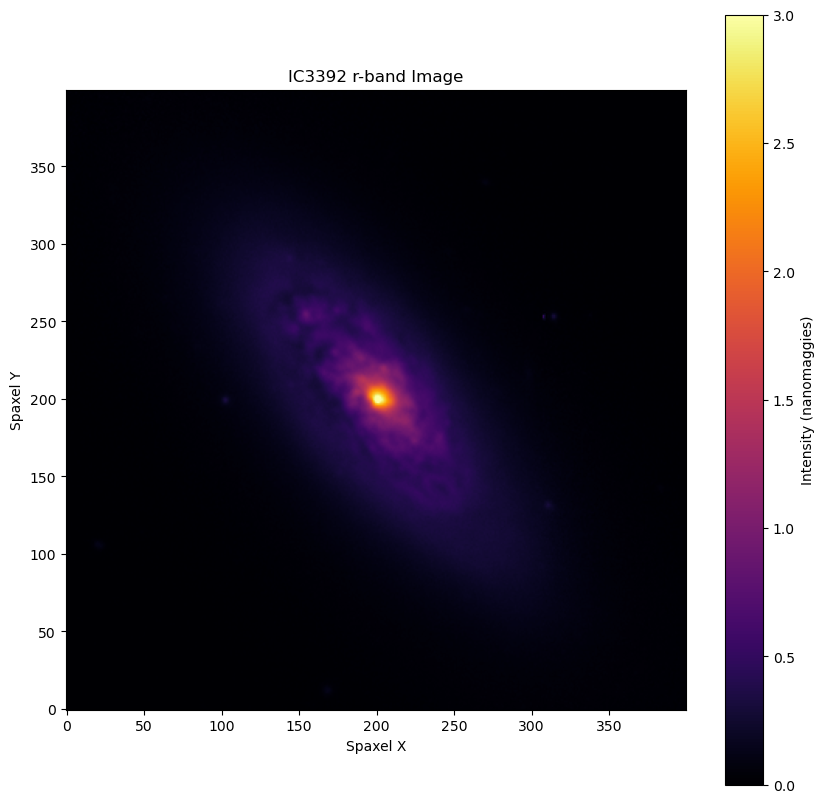

In [2]:
legacy_file = Path("IC3392_DESI_grih_400.fits")
legacy_hdu  = fits.open(legacy_file)[0]
legacy_dat  = legacy_hdu.data
legacy_hdr  = legacy_hdu.header
legacy_wcs2 = WCS(legacy_hdr).celestial            # strip 3rd axis

g_band_flux = legacy_dat[0]  # Assuming the first slice is the g-band flux
r_band_flux = legacy_dat[1]  # Assuming the first slice is the r-band flux
i_band_flux = legacy_dat[2]  # Assuming the second slice is the i-band flux
h_band_flux = legacy_dat[3]  # Assuming the second slice is the h-band flux

# Plot the data using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(r_band_flux, cmap='inferno', origin='lower', vmin=0, vmax=3)
plt.colorbar(label='Intensity (nanomaggies)')
plt.title(f"IC3392 r-band Image")
# plt.xlim(r_band_flux.shape[0]/2-0.2/0.262*half_zoom, r_band_flux.shape[0]/2+0.2/0.262*half_zoom)
# plt.ylim(r_band_flux.shape[0]/2-0.2/0.262*half_zoom, r_band_flux.shape[0]/2+0.2/0.262*half_zoom)
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

In [3]:
# reference header (MUSE)
with fits.open("IC3392_SPATIAL_BINNING_maps.fits") as hd_m:
    ny, nx   = hd_m[1].data.shape
    muse_hdr = hd_m[1].header
    muse_flux = hd_m['FLUX'].data          # 2-D, same size as BINID
    
# Create proper NaN mask - check for NaN in the flux map
nan_mask = ~np.isfinite(muse_flux)         # True where original data are NaN

target_hdr = muse_hdr.copy()
for k in ('CTYPE3','CUNIT3','CRVAL3','CRPIX3','CDELT3','CD3_3','PC3_3'):
    target_hdr.pop(k, None)
target_hdr['NAXIS']=2; target_hdr['NAXIS1']=nx; target_hdr['NAXIS2']=ny

# CRITICAL: Check pixel scales for flux conservation
legacy_pixscale = np.abs(legacy_hdr['CD1_1']) * 3600  # arcsec/pixel
muse_pixscale = np.abs(muse_hdr['CDELT1']) * 3600     # arcsec/pixel
scale_factor = (legacy_pixscale / muse_pixscale)**2   # area ratio

In [4]:
legacy_wcs2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 187.1803186473 14.99943425062 
CRPIX : 200.5 200.5 
CD1_1 CD1_2  : -7.27777777777778e-05 0.0 
CD2_1 CD2_2  : 0.0 7.27777777777778e-05 
NAXIS : 400  400

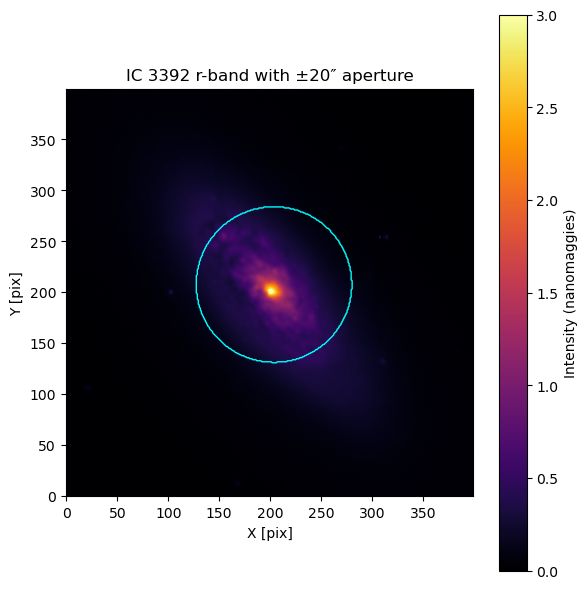

Total r-band flux inside ±20″ aperture: 7968.000 nanomaggies


In [5]:
#!/usr/bin/env python
"""
Create a ±10″ circular aperture centred on (RA, Dec) = (187.18°, 15.00°)
in the IC3392_DESI_grih_400.fits data cube and plot/measure the r-band
flux inside it.
"""
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs.utils import proj_plane_pixel_scales
# from photutils.aperture import SkyCircularAperture   # optional

# ------------------------------------------------------------------
# 1. Load the DESI cube and build a 2-D celestial WCS
# ------------------------------------------------------------------
legacy_file = Path("IC3392_DESI_grih_400.fits")
with fits.open(legacy_file) as hdul:
    legacy_dat = hdul[0].data         # shape (4, 400, 400)
    legacy_hdr = hdul[0].header
legacy_wcs2 = WCS(legacy_hdr).celestial  # strip spectral axis

# Split the four broadband images
g_band_flux, r_band_flux, i_band_flux, h_band_flux = legacy_dat

# ------------------------------------------------------------------
# 2. Sky-→-pixel transform for the requested centre
# ------------------------------------------------------------------
sky_cen = SkyCoord(ra=187.18*u.deg, dec=15.0*u.deg, frame='fk5')
x_cen, y_cen = legacy_wcs2.world_to_pixel(sky_cen)   # floats, not ints

# ------------------------------------------------------------------
# 3. Convert ±10 arcsec to pixels
# ------------------------------------------------------------------
pixscale = (proj_plane_pixel_scales(legacy_wcs2) * u.deg).to(u.arcsec)  # ≈0.262″
r_arcsec = 20.0 * u.arcsec
r_pix    = (r_arcsec / pixscale.mean()).value        # ≈38 pixels

# ------------------------------------------------------------------
# 4A. NumPy aperture mask  (pure-NumPy, no extra deps)
# ------------------------------------------------------------------
ny, nx = r_band_flux.shape
Y, X = np.ogrid[:ny, :nx]
mask = ((X - x_cen)**2 + (Y - y_cen)**2) <= r_pix**2   # Boolean array

# ------------------------------------------------------------------
# 4B. Photutils alternative (commented out)
# ------------------------------------------------------------------
# ap = SkyCircularAperture(sky_cen, r=r_arcsec)
# mask = ap.to_mask(method='center').to_image((ny, nx)).astype(bool)

# ------------------------------------------------------------------
# 5. Quick visual sanity-check
# ------------------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(r_band_flux, origin='lower', cmap='inferno', vmin=0, vmax=3)
plt.colorbar(label=r'Intensity (nanomaggies)')
plt.contour(mask, levels=[0.5], colors='cyan', linewidths=1)
plt.title("IC 3392 r-band with ±20″ aperture")
plt.xlabel("X [pix]")
plt.ylabel("Y [pix]")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 6. Use the mask: total r-band flux inside ±10″
# ------------------------------------------------------------------
total_r_flux = r_band_flux[mask].sum()
print(f"Total r-band flux inside ±20″ aperture: {total_r_flux:.3f} nanomaggies")


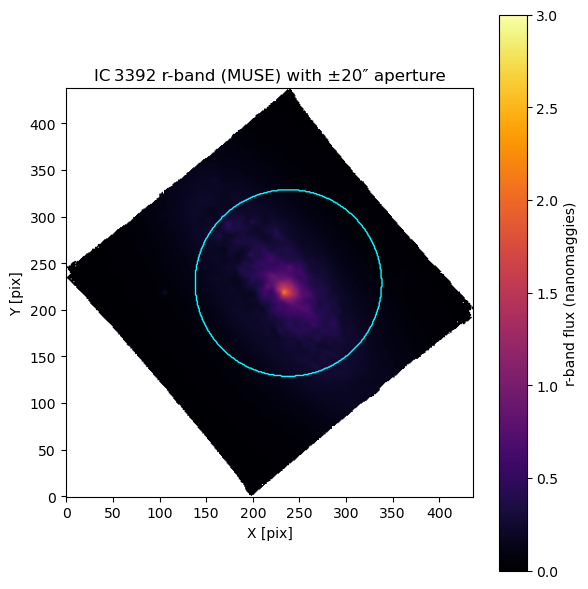

Total r-band flux inside ±20″ aperture: 8035.229 nanomaggies


In [6]:
#!/usr/bin/env python
"""
Make an r-band nanomaggie map from the MUSE cube, plot it with a ±10″
aperture centred on (RA,Dec)=(187.18°, 15.00°), and print the enclosed flux.
"""
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import SkyCoord
import astropy.units as u
from speclite import filters

# ------------------------------------------------------------------
# 1)  Load the MUSE cube and build wavelength array
# ------------------------------------------------------------------
cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
with fits.open(cube_path, memmap=False) as hdul:
    datacube = hdul["DATA"].data.astype(np.float32)           # (nz, ny, nx)
    hdr      = hdul["DATA"].header
nz, ny, nx = datacube.shape

spec_wcs = WCS(hdr).sub(["spectral"])                         # 1-axis WCS
wave = (spec_wcs.all_pix2world(np.arange(nz)[:, None], 0)[:, 0] *
        spec_wcs.wcs.cunit[0]).to(u.AA)                       # (nz,) Å

# ------------------------------------------------------------------
# 2)  Attach units and vectorised r-band photometry
# ------------------------------------------------------------------
F_lambda = datacube * (1e-20 * u.erg / (u.s * u.cm**2 * u.AA))     # (nz,ny,nx)
flux_cube = F_lambda.transpose(1, 2, 0)                            # (ny,nx,nz)

f_r = filters.load_filter("bessell-r")                             # any SDSS-like r
maggies_map = f_r.get_ab_maggies(flux_cube, wave, axis=-1)   # (ny,nx) :contentReference[oaicite:0]{index=0}
nmag_map = (maggies_map * 1e9).astype(np.float32)                  # → nanomaggies
# 1 maggie = 3631 Jy; 1 nanomaggie ≃ 3.631 µJy :contentReference[oaicite:1]{index=1}

# ------------------------------------------------------------------
# 3)  Build the ±10″ aperture mask on the MUSE spatial grid
# ------------------------------------------------------------------
cel_wcs = WCS(hdr).celestial
pixscale = (proj_plane_pixel_scales(cel_wcs) * u.deg).to(u.arcsec)  # ≈0.2″/pix
r_pix = (20.0*u.arcsec / pixscale.mean()).value                    

sky_cen = SkyCoord(187.18*u.deg, 15.00*u.deg, frame="fk5")
x0, y0 = cel_wcs.world_to_pixel(sky_cen)                            # floats :contentReference[oaicite:2]{index=2}
Y, X = np.ogrid[:ny, :nx]
mask = (X - x0)**2 + (Y - y0)**2 <= r_pix**2                       # Boolean

# ------------------------------------------------------------------
# 4)  Plot map + aperture and report enclosed flux
# ------------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.imshow(nmag_map, origin="lower", cmap="inferno", vmin=0, vmax=3)
plt.colorbar(label="r-band flux (nanomaggies)")
plt.contour(mask, levels=[0.5], colors="cyan", linewidths=1)
plt.title("IC 3392 r-band (MUSE) with ±20″ aperture")
plt.xlabel("X [pix]"); plt.ylabel("Y [pix]")
plt.tight_layout(); plt.show()

total_r_flux = np.nansum(nmag_map[mask])
print(f"Total r-band flux inside ±20″ aperture: {total_r_flux:.3f} nanomaggies")


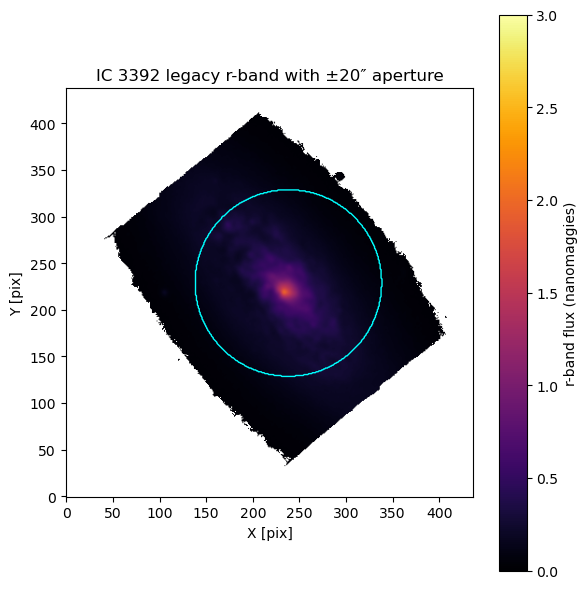

Total r-band flux inside ±20″ aperture: 7966.787 nanomaggies


In [7]:
#!/usr/bin/env python
"""
Measure r-band flux inside a ±10″ circular aperture in the
IC3392_legacy_to_MUSE_with_fp.fits FLUX cube (units = nanomaggies).
"""
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import SkyCoord
import astropy.units as u

# ---------------------------------------------------------------
# 1)  Open the legacy-on-MUSE cube and build a 2-D celestial WCS
# ---------------------------------------------------------------
fn = Path("IC3392_legacy_to_MUSE_with_fp.fits")
with fits.open(fn) as hdul:
    cube_flux = hdul["FLUX"].data.astype(np.float32)       # shape (4, ny, nx)
    hdr       = hdul["FLUX"].header                        # carries 2-D TAN WCS
cel_wcs = WCS(hdr).celestial

# unpack the four bands (g r i h); r = index 1
g_band, r_band, i_band, h_band = cube_flux
ny, nx = r_band.shape

# ---------------------------------------------------------------
# 2)  Build the ±10″ (*see note*) aperture mask
# ---------------------------------------------------------------
sky_cen = SkyCoord(187.18*u.deg, 15.00*u.deg, frame="fk5")
x0, y0  = cel_wcs.world_to_pixel(sky_cen)                  # centre in pixels

pixscale = (proj_plane_pixel_scales(cel_wcs) * u.deg).to(u.arcsec)
R_ARCSEC = 20.0 * u.arcsec          # change here if you really meant 20″ radius
r_pix    = (R_ARCSEC / pixscale.mean()).value

Y, X = np.ogrid[:ny, :nx]
mask = (X - x0)**2 + (Y - y0)**2 <= r_pix**2              # Boolean aperture mask

# ---------------------------------------------------------------
# 3)  Plot the r-band map with aperture overlay
# ---------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.imshow(r_band, origin="lower", cmap="inferno",
           vmin=0, vmax=3)
plt.colorbar(label="r-band flux (nanomaggies)")
plt.contour(mask, levels=[0.5], colors="cyan", linewidths=1)
plt.title(f"IC 3392 legacy r-band with ±{R_ARCSEC.value:.0f}″ aperture")
plt.xlabel("X [pix]"); plt.ylabel("Y [pix]")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# 4)  Flux inside aperture
# ---------------------------------------------------------------
total_r_flux = np.nansum(r_band[mask])
print(f"Total r-band flux inside ±{R_ARCSEC.value:.0f}″ aperture: "
      f"{total_r_flux:.3f} nanomaggies")
